In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy

# Dim Reduction
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
import umap

# NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

# Classifiers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("goodreads_books.csv", header=0)

data.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


In [3]:
data.dtypes

id                          int64
title                      object
link                       object
series                     object
cover_link                 object
author                     object
author_link                object
rating_count                int64
review_count                int64
average_rating            float64
five_star_ratings           int64
four_star_ratings           int64
three_star_ratings          int64
two_star_ratings            int64
one_star_ratings            int64
number_of_pages           float64
date_published             object
publisher                  object
original_title             object
genre_and_votes            object
isbn                       object
isbn13                     object
asin                       object
settings                   object
characters                 object
awards                     object
amazon_redirect_link       object
worldcat_redirect_link     object
recommended_books          object
books_in_serie

In [4]:
print(f"Date shape: {data.shape}")

Date shape: (52199, 31)


## Date formatting

In [14]:
day_dict = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th',
            '10th','11th','12th','13th','14th','15th','16th','17th','18th','19th',
            '20th','21st','22nd','23rd','24th','25th','26th','27th','28th','29th',
            '30th','31st']
day_dict = dict(zip( day_dict,range(1,32) ))

month_dict = ['January','February','March','April','May','June',
             'July','August','September','October','November','December']
month_dict = dict(zip( month_dict,np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30]) ))

In [15]:
tmp = data['date_published'].str.rsplit(' ', expand=False)

date_list = np.zeros((len(tmp),), dtype=int)
for i in tmp.index[~pd.isna(tmp)]:
    date = tmp[i]
    date_sum = 0
    
    for part in date:
        if part in month_dict:
            date_sum += month_dict[part]
        elif part in day_dict:
            date_sum += day_dict[part]
        else:
            date_sum += int(part)*365

    date_list[i] = date_sum

In [16]:
data['date_published_numeric'] = date_list

In [17]:
data['date_published_numeric']

0        732556
1        732492
2        733286
3        728905
4        728476
          ...  
52194    732555
52195    735208
52196    715765
52197    732669
52198    733286
Name: date_published_numeric, Length: 52199, dtype: int64

In [18]:
print("Books Published Before Year 0:")
data[data['date_published_numeric'] < 0][['title','date_published']]

Books Published Before Year 0:


,title,date_published
163,Tanakh: The Holy Scriptures,-450
255,The I Ching or Book of Changes,-850
736,The Analects,-429
2692,Homeric Hymns,-600
3397,Phaedo,-380
...,...,...
49706,The Bacchae,-405
49888,The Torah: The Five Books of Moses,-400
50541,The Conquest of Gaul,-50
51922,The Art of Love,-1


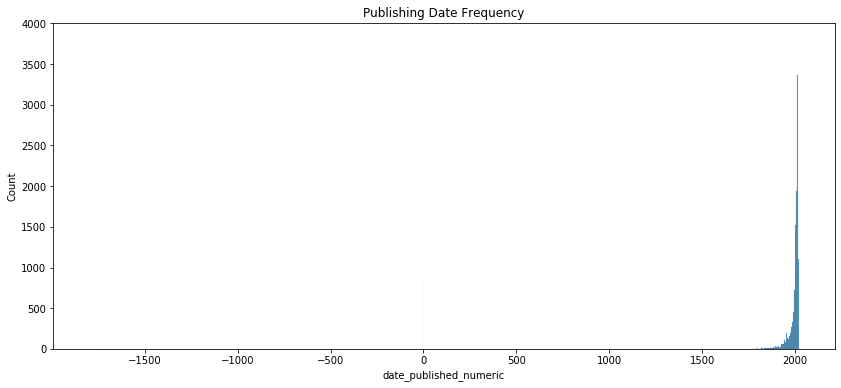

In [19]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Publishing Date Frequency")
sns.histplot(data['date_published_numeric']/365, ax=ax);

This graph is just to demonstrate that most books were published in the recent past, but there are exceptions such as religious texts.

### Count awards

Make feature that counts the number of awards each book received.

In [20]:
ind = data['awards'].notna()
data['awards_count'] = data['awards'][ind].str.split(',').map(len)
data['awards_count'].fillna(0, inplace=True)
data['awards_count'] = data['awards_count'].astype('int32')

In [21]:
data['awards_count']

0        0
1        0
2        0
3        0
4        1
        ..
52194    0
52195    2
52196    2
52197    0
52198    0
Name: awards_count, Length: 52199, dtype: int32

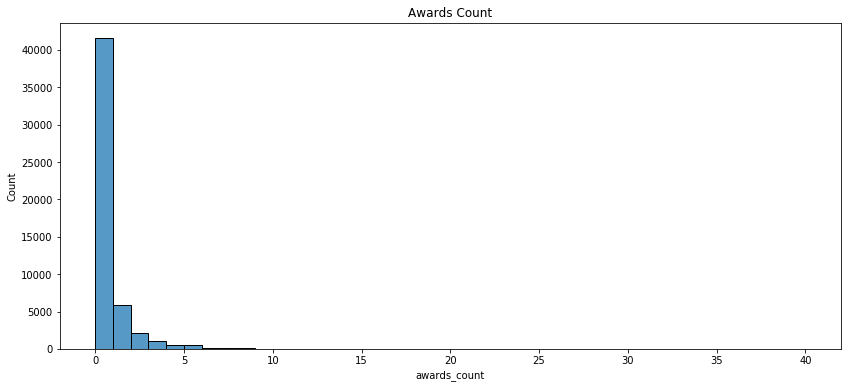

In [22]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Awards Count")
sns.histplot(data['awards_count'], binwidth=1, ax=ax);

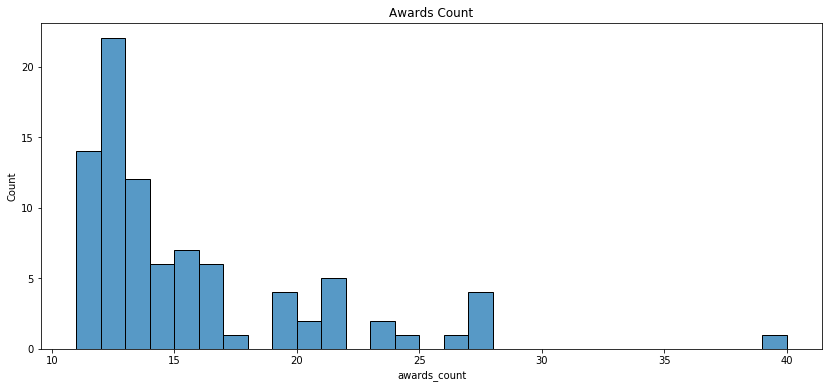

In [23]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Awards Count")
sns.histplot(data['awards_count'][data['awards_count']>10], binwidth=1, ax=ax);

The Hunger Games is an outlier. I think this indicates that a particularly zealous user listed all of the awards won by this book, not that the Hunger Games is the most awarded book of all time.

In [24]:
data['title'][data['awards_count']==40]

41514    The Hunger Games
Name: title, dtype: object

In [25]:
data[data['awards_count']==40]['awards'].iloc[0]

"Locus Award Nominee for Best Young Adult Book (2009), Georgia Peach Book Award (2009), Buxtehuder Bulle (2009), Golden Duck Award for Young Adult (Hal Clement Award) (2009), Grand Prix de l'Imaginaire Nominee for Roman jeunesse Ã©tranger (2010) Books I Loved Best Yearly (BILBY) Awards for Older Readers (2012), West Australian Young Readers' Book Award (WAYRBA) for Older Readers (2010), Red House Children's Book Award for Older Readers & Overall (2010), South Carolina Book Award for Junior and Young Adult Book (2011), Charlotte Award (2010), Colorado Blue Spruce Young Adult Book Award (2010), Teen Buckeye Book Award (2009), Pennsylvania Young Readers' Choice Award for Young Adults (2010), Rhode Island Teen Book Award (2010), Dorothy Canfield Fisher Children's Book Award (2010), Evergreen Teen Book Award (2011), Soaring Eagle Book Award (2009), Milwaukee County Teen Book Award Nominee (2010), Sakura Medal for Middle School Book (2010), Michigan Library Association Thumbs Up! Award (2009

### Page number

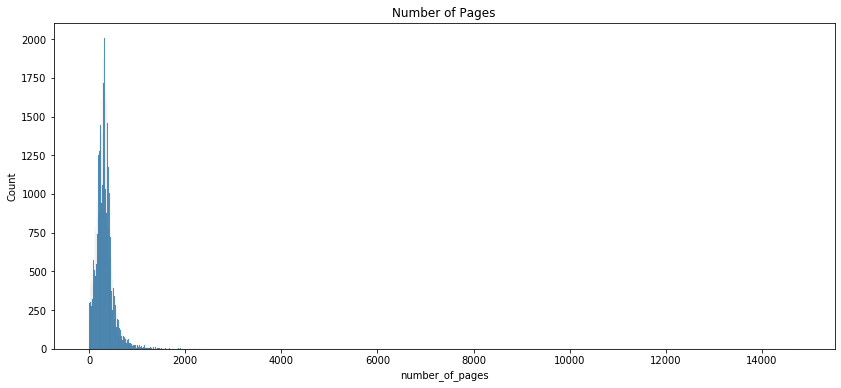

In [26]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Number of Pages")
sns.histplot(data['number_of_pages'], ax=ax);

### Genre 

Here, we do some pre-processing to convert the genre feature into a set of numerical features.

In [27]:
print("Genre example:")
data['genre_and_votes'][901]

Genre example:


'Fantasy-Urban Fantasy 474, Fantasy 230, Fantasy-Paranormal 164, Mystery 101, Fiction 74, Fantasy-Supernatural 50, Paranormal-Ghosts 49, Paranormal-Vampires 48, Horror 30, Fantasy-Magic 24'

In [28]:
stage_1 = data['genre_and_votes'].str.split(',') # Split the string into a list, one entry per genre
stage_2 = stage_1.explode().str.strip()          # 
stage_3 = stage_2.str.rsplit(' ', n=1, expand=True)
stage_4 = stage_3.pivot(columns=0)[1].iloc[:,1:]
stage_4 = stage_4.fillna(0).replace('1user',1)   # Clean up missing values and one odd aberation

In [29]:
genre_columns = stage_4.columns

In [30]:
data = pd.concat([data,stage_4],axis=1)

In [31]:
data.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,Young Adult,Young Adult-Coming Of Age,Young Adult-High School,Young Adult-Teen,Young Adult-Young Adult Contemporary,Young Adult-Young Adult Fantasy,Young Adult-Young Adult Historical Fiction,Young Adult-Young Adult Paranormal,Young Adult-Young Adult Romance,Young Adult-Young Adult Science Fiction
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,161,0,0,0,0,0,0,0,0,0
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,0,0,0,0,0,0,0,0,0,0
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,0,0,0,0,0,0,0,0,0,0
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,0,0,0,0,0,0,0,0,0,0
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,0,0,0,0,0,0,0,0,0,0


### Average Rating

Our target variable, average rating, clearly fits a gaussian distribution centered on the number 4. This would make regression an easy task, but it poses difficulties if we wish to transfrom this into a binary classification problem between "good" and "bad" books.

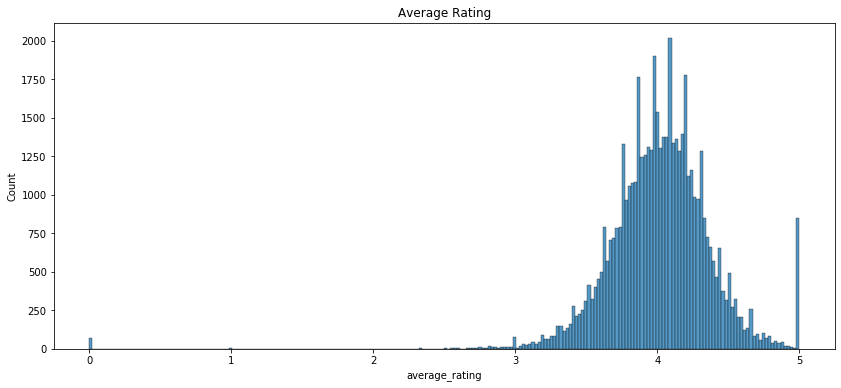

In [32]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Average Rating")
sns.histplot(data['average_rating'], ax=ax);

## Classification features

Choose feature space for classification task.

In [33]:
features = ['date_published_numeric','number_of_pages','awards_count'] #genre, publisher

## Missing Values

"awards_count" cannot have missing values; if a book has no awards listed, then it simply has awards_count = 0. Therefore, we do not consider this feature.

In [34]:
nan_features_check = ['date_published','number_of_pages','description','genre_and_votes','average_rating']

In [35]:
# Percentage of each column that is NaN
(data.isna().sum() / data.shape[0])[nan_features_check]

date_published     0.016475
number_of_pages    0.044637
description        0.049330
genre_and_votes    0.054407
average_rating     0.000000
dtype: float64

In [36]:
#subset = ['date_published','number_of_pages','average_rating','description','genre_and_votes']
result = data[nan_features_check].isna().any(axis='columns').sum() / data[nan_features_check].shape[0]
print(f"Percentage of samples with missing data: {result}")

Percentage of samples with missing data: 0.12969597118718748


Each of these features is missing less than $\leq5\%$ of its values. In total, 13% of the dataset is missing one of these features. I feel comfortable dropping those data samples entirely.

In [37]:
# Drop samples with missing values
data = data.dropna(subset=nan_features_check)

# Percentage of each column that is NaN
(data.isna().sum() / data.shape[0])[nan_features_check]

date_published     0.0
number_of_pages    0.0
description        0.0
genre_and_votes    0.0
average_rating     0.0
dtype: float64

## Outliers

### Consider Features Together:

In [38]:
features

['date_published_numeric', 'number_of_pages', 'awards_count']

In [39]:
# Local Outlier Factor
cov = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_outlier = cov.fit_predict( data[features] )

# Robust Covariance, Mahalanobis distance
cov = EllipticEnvelope(contamination=0.05)
rc_outlier = cov.fit_predict( data[features] )

# Isolation Forest
cov = IsolationForest(n_estimators=100,  contamination=0.05)
if_outlier = cov.fit_predict( data[features] )

# Count up which rows have been counted as outliers and how many times
all_outliers = (if_outlier==-1).astype(int) + (rc_outlier==-1).astype(int) + (lof_outlier==-1).astype(int)

print("Rows counted as outliers by")
print(f"One method: {(all_outliers == 1).sum()}")
print(f"Two methods: {(all_outliers == 2).sum()}")
print(f"Three methods: {(all_outliers == 3).sum()}")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Rows counted as outliers by
One method: 3233
Two methods: 1601
Three methods: 127


In [40]:
print("Outliers:")
data[['title']+features][all_outliers == 3]

Outliers:


,title,date_published_numeric,number_of_pages,awards_count
255,The I Ching or Book of Changes,-310250,740.0,0
262,Beggars in Spain,727476,400.0,5
265,The Message Remix (Bible in Contemporary Langu...,728965,2272.0,1
575,The New American Bible,693135,1394.0,0
771,The Story of Civilization,720875,14777.0,0
...,...,...,...,...
49801,The Complete Malazan Book of the Fallen,735138,8258.0,0
50533,"The Sword of Truth, Boxed Set I: Wizard's Firs...",729589,2480.0,0
51300,Foxe's Book of Martyrs,570495,416.0,0
51460,"Gun, With Occasional Music",727869,271.0,5


In [41]:
print("Whole dataset statistics:")
data[features].describe()

Whole dataset statistics:


,date_published_numeric,number_of_pages,awards_count
count,45429.000000,45429.000000,45429.000000
mean,725437.590086,334.520813,0.475313
std,45645.606387,251.821659,1.306101
min,-657000.000000,0.000000,0.000000
25%,727445.000000,221.000000,0.000000
50%,732555.000000,309.000000,0.000000
75%,734599.000000,398.000000,0.000000
max,737740.000000,14777.000000,40.000000


In [42]:
print("Outlier Statistics:")
data[['title']+features][all_outliers == 3].describe()

Outlier Statistics:


,date_published_numeric,number_of_pages,awards_count
count,127.000000,127.000000,127.000000
mean,582509.464567,1795.787402,3.228346
std,337430.475398,2331.221022,5.998927
min,-657000.000000,30.000000,0.000000
25%,692952.500000,299.000000,0.000000
50%,722029.000000,776.000000,0.000000
75%,730000.000000,2456.000000,5.000000
max,736313.000000,14777.000000,40.000000


The comparing the means of the outliers and the whole dataset demonstrates what kinds of outliers are being detected. The 'date_published_numeric' outliers are lower on average, while the 'number_of_pages' and 'awards_count' outliers are higher. This makes sense; it is very rare for a book to be 1800 pages long, and it is relatively uncommon for a book to be published begore year zero.

In [43]:
# Remove all datapoints that have been designated outliers by at least two methods
data = data.loc[np.invert(all_outliers >= 2),:]

### Consider Features Separately

In [44]:
for f in features:
    # Local Outlier Factor
    cov = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_outlier = cov.fit_predict( data[[f]] )

    # Robust Covariance, Mahalanobis distance
    cov = EllipticEnvelope(contamination=0.05, support_fraction=0.9)
    rc_outlier = cov.fit_predict( data[[f]] )

    # Isolation Forest
    cov = IsolationForest(n_estimators=100,  contamination=0.05)
    if_outlier = cov.fit_predict( data[[f]] )

    # Count up which rows have been counted as outliers and how many times
    all_outliers = (if_outlier==-1).astype(int) + (rc_outlier==-1).astype(int) + (lof_outlier==-1).astype(int)
    
    print(f"Searching for outliers in: {f}")
    print(f"Number of outliers found: {(all_outliers == 3).sum()}")
    
    # Remove all datapoints that have been designated outliers by at least two methods
    data = data.loc[np.invert(all_outliers == 3),:]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Searching for outliers in: date_published_numeric
Number of outliers found: 166


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Searching for outliers in: number_of_pages
Number of outliers found: 841


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Searching for outliers in: awards_count
Number of outliers found: 0


In [45]:
data.shape

(42694, 904)

We have dropped from about 52000 rows to 42000 rows, losing about a fifth of our data.

Below, you can see that the outlier detection process naturally removed many of the worst offenders.

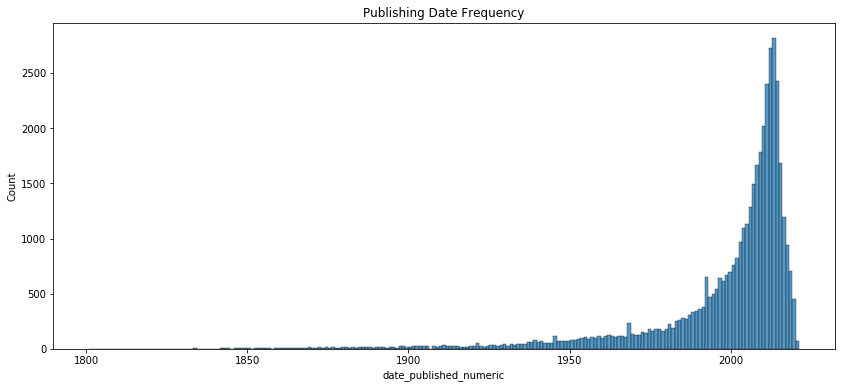

In [46]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Publishing Date Frequency")
sns.histplot(data['date_published_numeric']/365, ax=ax);

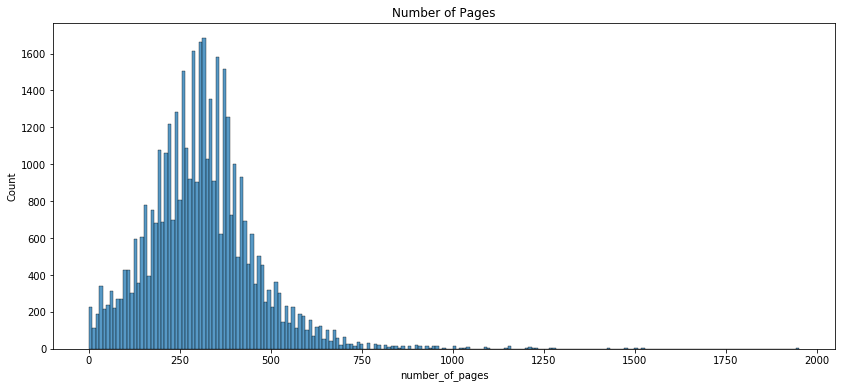

In [47]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_title("Number of Pages")
sns.histplot(data['number_of_pages'], ax=ax);

## Classification features

Choose feature space for classification task.

In [175]:
feature_space = data[features]
feature_space

,date_published_numeric,number_of_pages,awards_count
0,732556,220.0,0
1,732492,400.0,0
2,733286,320.0,0
4,728476,258.0,1
5,717650,252.0,0
...,...,...,...
52194,732555,312.0,0
52195,735208,208.0,2
52196,715765,264.0,2
52197,732669,240.0,0


## Make Target Classes

In [49]:
# High=1, Low=0
target = pd.DataFrame( np.where(data['average_rating']>3.5, 1, 0) )

In [50]:
print(f'Class Imbalance of Rating target:' )
target.value_counts()

Class Imbalance of Rating target:


1    40390
0     2304
dtype: int64

## Dimensionality Reduction

There are 871 distinct genre features. Can we use clustering/dimensionality reduction to find the most important genres?

In [166]:
def dim_plot(data, color):
    # Visualize first three components
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = data[:, 0], data[:, 1], data[:, 2]
    ax.scatter(x, y, z, c=color, s=10, alpha=0.5)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title('PCA - First 3 Components')

    plt.show()

In [167]:
n_components = 200

In [168]:
# Perform PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data[genre_columns])

In [169]:
# Display variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Variance explained by each component:")
for i, (evr, cev) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance), start=1):
    if i < 20:
        print(f"Component {i}: {evr*100:.2f}% (cumulative: {cev*100:.2f}%)")

Variance explained by each component:
Component 1: 37.77% (cumulative: 37.77%)
Component 2: 25.41% (cumulative: 63.18%)
Component 3: 5.80% (cumulative: 68.98%)
Component 4: 4.80% (cumulative: 73.78%)
Component 5: 3.90% (cumulative: 77.68%)
Component 6: 2.90% (cumulative: 80.58%)
Component 7: 2.31% (cumulative: 82.88%)
Component 8: 2.01% (cumulative: 84.89%)
Component 9: 1.79% (cumulative: 86.68%)
Component 10: 1.43% (cumulative: 88.11%)
Component 11: 1.11% (cumulative: 89.22%)
Component 12: 1.04% (cumulative: 90.26%)
Component 13: 0.82% (cumulative: 91.08%)
Component 14: 0.77% (cumulative: 91.86%)
Component 15: 0.62% (cumulative: 92.47%)
Component 16: 0.58% (cumulative: 93.05%)
Component 17: 0.46% (cumulative: 93.51%)
Component 18: 0.42% (cumulative: 93.93%)
Component 19: 0.37% (cumulative: 94.29%)


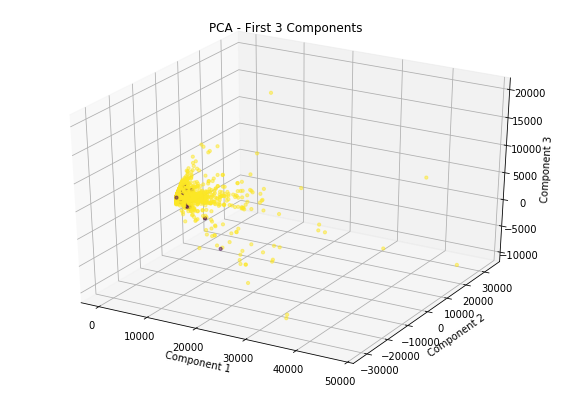

In [170]:
dim_plot(pca_result[:,:3], target.to_numpy().flatten())

In [56]:
#pca = SparsePCA(n_components=20)
#pca_result = pca.fit_transform(data[genre_columns])

In [57]:
# Display variance explained by each component
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# print("Variance explained by each component:")
# for i, (evr, cev) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance), start=1):
#     if i < 10:
#         print(f"Component {i}: {evr*100:.2f}% (cumulative: {cev*100:.2f}%)")

### UMAP

In [171]:
umap_model = umap.UMAP(n_components=n_components, random_state=0)
umap_model.fit( data[genre_columns].iloc[:1000,:] )


UMAP(n_components=200, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [172]:
umap_result = umap_model.transform( data[genre_columns] )

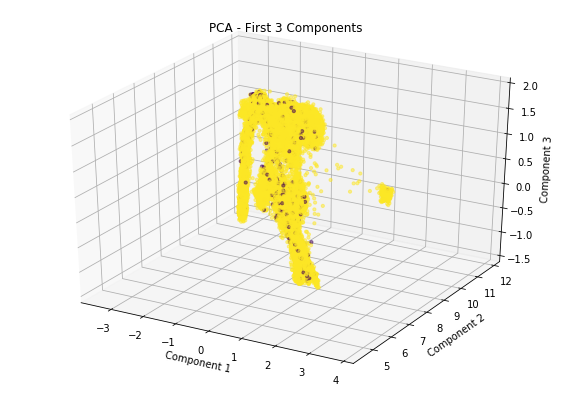

In [60]:
dim_plot(umap_result[:,:3], target.to_numpy().flatten())

In [173]:
dim_red_result = umap_result

In [174]:
dim_red_result = pd.DataFrame(data=dim_red_result, columns=["Genre "+str(i) for i in range(n_components)])
dim_red_result

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,...,Genre 190,Genre 191,Genre 192,Genre 193,Genre 194,Genre 195,Genre 196,Genre 197,Genre 198,Genre 199
0,0.401139,7.513934,-0.983425,3.124677,7.777444,10.256311,5.557380,4.339895,5.059735,4.121490,...,5.391957,4.986638,4.788271,4.458261,3.829104,4.167898,4.867033,4.878174,3.891680,5.226994
1,0.718018,7.022974,-1.856163,2.946453,7.865166,10.526792,6.101334,5.158705,4.570004,4.113412,...,5.128796,5.013435,4.692409,4.218020,3.909405,4.138640,4.973183,4.825973,3.919778,5.189005
2,0.787019,6.946011,-1.895412,2.947062,7.886247,10.601449,6.134842,5.253975,4.560320,4.135774,...,5.112076,5.017207,4.694026,4.215303,3.896044,4.135749,4.973501,4.814440,3.925729,5.182456
3,-1.909626,11.130042,-4.368726,2.531094,7.007669,12.688078,5.735023,5.820513,5.203997,3.782926,...,4.958140,5.311049,4.523271,4.263134,3.824207,3.988621,4.852787,4.667660,3.696894,5.145448
4,1.065860,6.730938,-1.551436,2.332492,7.089417,10.300221,6.416355,5.648290,4.504544,3.838565,...,5.384787,4.888872,4.818115,4.278892,3.898338,4.125101,4.923999,4.864573,3.989892,5.257958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42689,0.853496,7.007957,-1.635746,2.282282,7.047070,10.328662,6.381402,5.520251,4.602662,3.826365,...,5.373257,4.894289,4.804361,4.271299,3.896813,4.102924,4.925584,4.872275,3.984000,5.248615
42690,-1.874331,11.237284,-4.540036,2.575938,7.052080,12.710847,5.855628,5.439118,5.083217,3.803868,...,4.951715,5.331209,4.508698,4.229072,3.836164,3.959926,4.897376,4.644936,3.669814,5.094580
42691,0.074173,7.655718,-1.941806,2.878164,7.862320,10.464359,5.912828,4.770049,4.792908,4.045306,...,5.117077,5.066905,4.648489,4.213526,3.914891,4.108509,4.981408,4.840713,3.874894,5.176481
42692,0.306822,7.613029,-0.928830,3.153642,7.699113,10.212525,5.557044,4.259286,5.056951,4.092164,...,5.397412,4.967041,4.788458,4.435040,3.841043,4.166580,4.874187,4.884877,3.902863,5.240404


## NLP on Descriptions

In [176]:
data['description'][~data['description'].isna()]

0        Reed Brennan arrived at Easton Academy expecti...
1        Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,...
2        Filmmakers Chase Ryan and Keith Ellison have c...
4        The incredible national bestseller that is cha...
5        With her high-spirited intelligence and good l...
                               ...                        
52194    The unabridged, downloadable audiobook edition...
52195    An affecting and hope-filled posthumous collec...
52196    6. August 1945, 8 Uhr 15 Minuten - die kleine ...
52197    Sometimes the truth hurts....     Reed Brennan...
52198    is the #1  bestselling memoir from Sarah Palin...
Name: description, Length: 42694, dtype: object

In [177]:
data['description'][10]

"Jim Butcher, the #1 New York Times bestselling author of The Dresden Files and the Codex Alera novels, conjures up a new series set in a fantastic world of noble families, steam-powered technology, and magic-wielding warriors.¦ Since time immemorial, the Spires have sheltered humanity, towering for miles over the mist-shrouded surface of the world. Within their halls, aristo Jim Butcher, the #1 New York Times bestselling author of The Dresden Files and the Codex Alera novels, conjures up a new series set in a fantastic world of noble families, steam-powered technology, and magic-wielding warriors.¦ Since time immemorial, the Spires have sheltered humanity, towering for miles over the mist-shrouded surface of the world. Within their halls, aristocratic houses have ruled for generations, developing scientific marvels, fostering trade alliances, and building fleets of airships to keep the peace. Captain Grimm commands the merchant ship,  . Fiercely loyal to Spire Albion, he has taken the

It looks like some characters, such as the apostrophe, were not properly recorded. I will replace some of the obvious offenders manually.

In [178]:
data['description'] = data['description'].str.replace('â\x80\x99', "'", regex=False)
data['description'] = data['description'].str.replace('â\x80\x94', "-", regex=False)
data['description'] = data['description'].str.replace('â\x80', ".", regex=False)

In [179]:
data['description'][10]

"Jim Butcher, the #1 New York Times bestselling author of The Dresden Files and the Codex Alera novels, conjures up a new series set in a fantastic world of noble families, steam-powered technology, and magic-wielding warriors.¦ Since time immemorial, the Spires have sheltered humanity, towering for miles over the mist-shrouded surface of the world. Within their halls, aristo Jim Butcher, the #1 New York Times bestselling author of The Dresden Files and the Codex Alera novels, conjures up a new series set in a fantastic world of noble families, steam-powered technology, and magic-wielding warriors.¦ Since time immemorial, the Spires have sheltered humanity, towering for miles over the mist-shrouded surface of the world. Within their halls, aristocratic houses have ruled for generations, developing scientific marvels, fostering trade alliances, and building fleets of airships to keep the peace. Captain Grimm commands the merchant ship,  . Fiercely loyal to Spire Albion, he has taken the

In [180]:
# Create an instance of CountVectorizer
# lowering max_df will limit the number of meaningless words (articles,conjunctions)
# raising min_df will limit the number of misspelled words and numbers
count_vectorizer = TfidfVectorizer(max_df=0.75,min_df=0.02)

# Fit and transform the 'text' column of the DataFrame
X = count_vectorizer.fit_transform(data['description'][~data['description'].isna()].iloc[:100000])

# Convert the transformed data back into a DataFrame
vectorized_df = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

# Print the resulting DataFrame
print(vectorized_df)

       able     about  acclaimed  across  action  adventure     after  again  \
0       0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
1       0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
2       0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
3       0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
4       0.0  0.000000        0.0     0.0     0.0        0.0  0.104643    0.0   
...     ...       ...        ...     ...     ...        ...       ...    ...   
42689   0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
42690   0.0  0.000000        0.0     0.0     0.0        0.0  0.054959    0.0   
42691   0.0  0.000000        0.0     0.0     0.0        0.0  0.000000    0.0   
42692   0.0  0.046874        0.0     0.0     0.0        0.0  0.000000    0.0   
42693   0.0  0.150872        0.0     0.0     0.0        0.0  0.000000    0.0   

       against  age  ...  writing  writ

In [181]:
print(f"Number of word features: {vectorized_df.columns.size}\n")
print(f"Word features: {vectorized_df.columns}")

Number of word features: 626

Word features: Index(['able', 'about', 'acclaimed', 'across', 'action', 'adventure', 'after',
       'again', 'against', 'age',
       ...
       'writing', 'written', 'wrong', 'year', 'years', 'yet', 'york', 'you',
       'young', 'your'],
      dtype='object', length=626)


In [182]:
# Add the genre data and word vectors to the data
feature_space = pd.concat([feature_space.reset_index(drop=True), dim_red_result, vectorized_df], axis=1)

In [183]:
feature_space.shape

(42694, 829)

In [184]:
feature_space.to_csv('feature_space_2.csv', index=False)
target.to_csv('target.csv', index=False)

In [6]:
feature_space = pd.read_csv("feature_space_2.csv", header=0)
target = pd.read_csv("target.csv", header=0)

In [7]:
feature_space.columns

Index(['date_published_numeric', 'number_of_pages', 'awards_count', 'Genre 0',
       'Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6',
       ...
       'writing', 'written', 'wrong', 'year', 'years', 'yet', 'york', 'you',
       'young', 'your'],
      dtype='object', length=829)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Regression

In [144]:
# Standardize
scaler = StandardScaler()
feature_space_standard = scaler.fit_transform(feature_space)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(feature_space_standard, data['average_rating'].to_numpy().flatten(),
                                                                test_size=0.2, random_state=0)

In [174]:
# This function accepts a classifer model as well as train/test data
# Outputs accuracy and confusion matrix
def regress(model, X_train, X_test, y_train, y_test):
    y_test = y_test.to_numpy().flatten()
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2s = r2_score(y_test, y_pred)
    
#     acc = accuracy_score(y_test, y_pred)

    # Confusion Matrix
#     confuse = pd.crosstab(y_pred, y_test, rownames=['y_pred'], colnames=['y_test'])
    
    return mse, r2s

In [175]:
# fit SGD Regressor on features space
sgd_reg = SGDRegressor(max_iter=1000,tol = 0.0001,early_stopping=False,warm_start=False,n_iter_no_change = 5)

mse, r2s = regress(sgd_reg, X_train, X_test, y_train, y_test)


print(f"Mean squared error: {mse}")
print(f"R2 value is {r2s}")

Mean squared error: 0.09248585796293989
R2 value is 0.04245174595606016


## Classification

In [89]:
X_train, X_test, y_train, y_test = train_test_split(feature_space, target.to_numpy().flatten(),
                                                                test_size=0.2, random_state=0)

In [90]:
# This function accepts a classifer model as well as train/test data
# Outputs accuracy and confusion matrix
def classify(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)

    # Confusion Matrix
    confuse = pd.crosstab(y_pred, y_test, rownames=['y_pred'], colnames=['y_test'])
    
    return acc, confuse

In [165]:
# fit XGBClassifier on feature space
xgb = XGBClassifier(n_estimators=1000,
                    max_depth = 20,
                    eta = 0.3,
                    min_child_weight = 5,
                    random_state=0)
# xgb = XGBClassifier(n_estimators=100, random_state=0)

acc, cross = classify(xgb, X_train, X_test, y_train, y_test)

print('XGBoost Accuracy:', acc)
print('\nConfusion Matrix:\n', cross)

XGBoost Accuracy: 0.9460124136315727

Confusion Matrix:
 y_test    0     1
y_pred           
0        11    15
1       446  8067


In [161]:
# fit XGBClassifier on feature space
xgb = XGBClassifier(n_estimators=500,
                    max_depth = 20,
                    eta = 0.5,
                    min_child_weight = 5,
                    random_state=0)
# xgb = XGBClassifier(n_estimators=100, random_state=0)

acc, cross = classify(xgb, X_train, X_test, y_train, y_test)

print('XGBoost Accuracy:', acc)
print('\nConfusion Matrix:\n', cross)

XGBoost Accuracy: 0.9409628675178634

Confusion Matrix:
 y_test    0     1
y_pred           
0        13    33
1       471  8020


In [142]:
clf = DecisionTreeClassifier(criterion='gini',
                             min_samples_split=3,
                             min_samples_leaf=1, random_state=0)

acc, cross = classify(clf, X_train, X_test, y_train, y_test)

print('Decision Tree Accuracy:', acc)
print('\nConfusion Matrix:\n', cross)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
CO2:

Decision Tree Accuracy: 0.8934051774628089

Confusion Matrix:
 y_test    0     1
y_pred           
0        45   471
1       439  7582


In [148]:
rf = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=3,
                            min_samples_leaf=1,
                            random_state=0)

acc, cross = classify(rf, X_train, X_test, y_train, y_test)

print('Random Forest Accuracy:', acc)
print('\nConfusion Matrix:\n', cross)

<ipython-input-141-3a18d81f68cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
Random Forest Accuracy: 0.9433056108703292

Confusion Matrix:
 y_test    0     1
y_pred           
1       484  8053


### Clustering

In [9]:
# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
import hdbscan
from sklearn import metrics

In [13]:
n_components = 200
n_clusters = n_components

In [14]:
genres = ["Genre "+str(i) for i in range(n_components)]
not_genres = [f not in genres for f in feature_space.columns]
not_genres = np.array(not_genres)

In [15]:
# Standardize
scaler = StandardScaler()
feature_space_standard = scaler.fit_transform(feature_space[feature_space.columns[~not_genres]])
feature_space_standard = pd.DataFrame(feature_space_standard, columns=genres)

In [155]:
feature_space_standard

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18,Genre 19
0,0.777766,-0.686244,-0.719640,1.401621,0.410168,-0.781745,-0.659786,-0.468616,-0.838009,0.309441,0.456302,-0.891487,0.229105,0.063681,-1.285683,0.367730,0.135037,-0.879726,-0.611217,-0.091065
1,0.682826,-0.833234,-0.860815,-0.152083,0.848347,0.645152,-0.449278,0.404573,-0.299885,1.160783,-1.231102,-0.825216,0.856046,0.940256,-0.370464,-0.611308,0.949429,-0.289362,-0.636535,-0.761778
2,0.609459,-0.912764,-1.031587,-0.184442,0.772083,0.829414,-0.380312,0.513276,-0.377556,1.381188,-1.385354,-0.921406,0.931754,0.837440,-0.276080,-0.680950,1.049242,-0.337964,-0.585958,-0.777355
3,-1.347248,0.938839,-1.912300,-1.294052,-1.163394,2.169381,0.497848,1.557583,-1.090175,0.261356,0.634230,0.377159,0.505040,0.671563,-0.682599,-2.021611,0.464229,0.714349,0.539379,-1.019273
4,0.404600,-1.118837,-0.054403,-1.035765,0.795296,-0.008275,-0.985416,0.337498,-0.899442,-0.122514,0.685793,0.145265,-0.179785,0.386195,-0.437868,0.695889,-0.013126,0.451648,0.690216,-0.169378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42689,0.314139,-0.953851,0.053436,-0.944485,0.646874,-0.009703,-0.813501,0.310986,-0.672355,-0.165535,0.577478,0.189822,-0.280213,0.232228,-0.356102,0.657135,-0.071794,0.503109,0.722114,-0.040353
42690,-1.236868,0.890506,-2.162835,-1.390815,-1.173398,2.199894,0.706526,1.347787,-1.131013,0.125828,0.829569,0.480278,0.493523,0.464242,-0.488170,-2.053301,0.992628,0.705911,0.840376,-0.868737
42691,0.530988,-0.406774,-0.461411,-0.088362,0.497211,0.191958,0.050447,0.362089,0.204878,0.948564,-1.562313,-0.500538,0.946130,0.686346,-0.379084,-0.850102,1.016834,-0.458322,-0.898013,-1.048822
42692,0.730368,-0.586618,-0.493439,1.497170,0.370486,-0.837294,-0.670918,-0.623209,-0.678456,0.192001,0.428188,-0.898688,0.181378,0.005604,-1.010328,0.438113,0.077423,-0.993944,-0.756987,0.021986


In [16]:
feature_space_standard.idxmax(axis=1).value_counts()

Genre 50     3009
Genre 138    2339
Genre 47     2176
Genre 5      1930
Genre 155    1812
             ... 
Genre 30        1
Genre 176       1
Genre 118       1
Genre 127       1
Genre 39        1
Length: 141, dtype: int64

In [17]:
cluster_labels = feature_space_standard.abs().idxmax(axis=1)

In [18]:
def cluster(model, X, y):
    # Flatten data
#     original_shape = X.shape
#     flattened_shape = (original_shape[0], original_shape[1]*original_shape[2])
#     X = X.reshape(flattened_shape)
    
    # Fit model, get results
    model.fit(X)
    labels = model.labels_
    
    # Print scores
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))  #[0,1], 1 is best
    print("Completeness: %0.3f" % metrics.completeness_score(y, labels))#[0,1], 1 is best
    print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))      #[0,1], 1 is best
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels)) #[-0.5,1], 1 is best

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    return n_clusters, labels

In [19]:
np.random.seed(0)
ind = np.random.randint(feature_space.shape[0], size=(10000,))

In [20]:
data_to_cluster_on = feature_space[feature_space.columns[not_genres]].iloc[ind]

In [147]:
# Clean data
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5)

print("Clean data results:\n")
n_clusters_found, labels = cluster(hdbscan_model, data_to_cluster_on, cluster_labels[ind])

print(f"\nNumber of clusters found: {n_clusters_found}")

Clean data results:

Homogeneity: 0.185
Completeness: 0.120
V-measure: 0.146
Adjusted Rand Index: 0.006

Number of clusters found: 447


In [193]:
# Clean data
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5)

print("Clean data results:\n")
n_clusters_found, labels = cluster(hdbscan_model, data_to_cluster_on, cluster_labels[ind])

print(f"\nNumber of clusters found: {n_clusters_found}")

Clean data results:

Homogeneity: 0.253
Completeness: 0.238
V-measure: 0.246
Adjusted Rand Index: 0.003

Number of clusters found: 447


In [152]:
kmeans = KMeans(n_clusters, random_state=0, max_iter=100)

print("Clean data results:\n")
n_clusters_found, labels = cluster(kmeans, data_to_cluster_on, cluster_labels[ind])

print(f"\nNumber of clusters found: {n_clusters_found}")

Clean data results:



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Homogeneity: 0.048
Completeness: 0.051
V-measure: 0.049
Adjusted Rand Index: 0.012

Number of clusters found: 20


In [21]:
kmeans = KMeans(n_clusters, random_state=0, max_iter=100)

print("Clean data results:\n")
n_clusters_found, labels = cluster(kmeans, data_to_cluster_on, cluster_labels[ind])

print(f"\nNumber of clusters found: {n_clusters_found}")

Clean data results:



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Homogeneity: 0.198
Completeness: 0.158
V-measure: 0.176
Adjusted Rand Index: 0.006

Number of clusters found: 200
